# This dataset will be used to compare stats for each platform (PC, Xbox, and PS4), analyze how they differ, and determine which platform performs better than the others.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import CSV Files

In [2]:
# Import the MICE-imputed CSV files for each platform
pc_df = pd.read_csv(r"C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_PC.csv")
ps4_df = pd.read_csv(r"C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_PS4.csv")
xbox_df = pd.read_csv(r"C:\Users\altaa\Documents\Apex-Legends-Dataset\Career_Stats_Dataset\Imputated Datasets\MICE_Imputed_Xbox.csv")

In [6]:
#Check Data Frames
print("PC DataFrame:")
print(pc_df.head())

# Check data types
print("\nPC DataFrame Data Types:")
print(pc_df.dtypes)

PC DataFrame:
  player_name  career_kills  career_wins  career_revives
0      User_1      384461.0      18657.0         17523.0
1      User_2      379276.0      21007.0         28765.0
2      User_3      357870.0      20440.0         31624.0
3      User_4      344453.0      12049.0         16916.0
4      User_5      286883.0      19839.0         61443.0

PC DataFrame Data Types:
player_name        object
career_kills      float64
career_wins       float64
career_revives    float64
dtype: object


In [8]:
def platform_analysis(df, platform_name):
    print(f"\n--- {platform_name} Platform Analysis ---")
    print("Shape:", df.shape)
    print("\nSummary Statistics:")
    print(df.drop(columns=['player_name']).describe())
    print("\nMissing Values Per Column:")
    print(df.drop(columns=['player_name']).isnull().sum())
    print("\nCorrelation Matrix:")
    print(df.drop(columns=['player_name']).corr())
    print("\nTop 5 Players by Career Kills:")
    print(df[['player_name', 'career_kills']].sort_values(by='career_kills', ascending=False).head())
    print("\nTop 5 Players by Career Wins:")
    print(df[['player_name', 'career_wins']].sort_values(by='career_wins', ascending=False).head())
    print("\nTop 5 Players by Career Revives:")
    print(df[['player_name', 'career_revives']].sort_values(by='career_revives', ascending=False).head())

# Run analysis for each DataFrame
platform_analysis(pc_df, "PC")
platform_analysis(ps4_df, "PS4")
platform_analysis(xbox_df, "Xbox")


--- PC Platform Analysis ---
Shape: (979, 4)

Summary Statistics:
        career_kills   career_wins  career_revives
count     979.000000    979.000000      979.000000
mean   107596.732380   6572.407559    12864.435138
std     34876.204968   2415.365602     4118.023989
min      1035.000000   1947.000000     3753.000000
25%     86615.500000   5163.500000    10812.000000
50%     96969.000000   5977.000000    11872.000000
75%    114684.000000   7337.000000    13792.000000
max    384461.000000  23953.000000    61443.000000

Missing Values Per Column:
career_kills      0
career_wins       0
career_revives    0
dtype: int64

Correlation Matrix:
                career_kills  career_wins  career_revives
career_kills        1.000000     0.800652        0.635155
career_wins         0.800652     1.000000        0.717577
career_revives      0.635155     0.717577        1.000000

Top 5 Players by Career Kills:
  player_name  career_kills
0      User_1      384461.0
1      User_2      379276.0
2   

# Visualization of the different platforms and there differences in stats

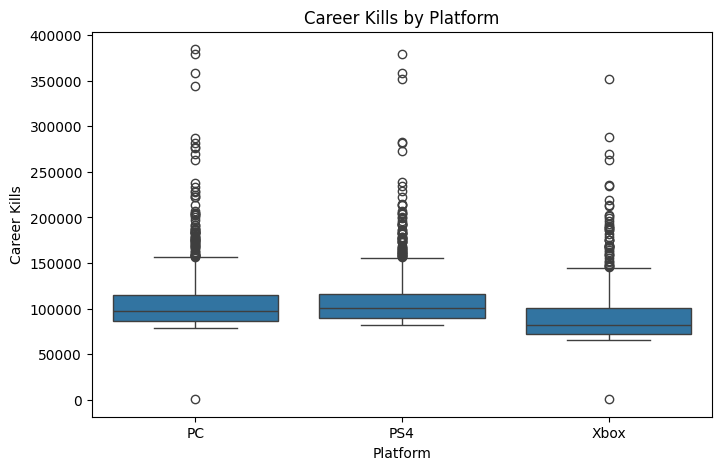

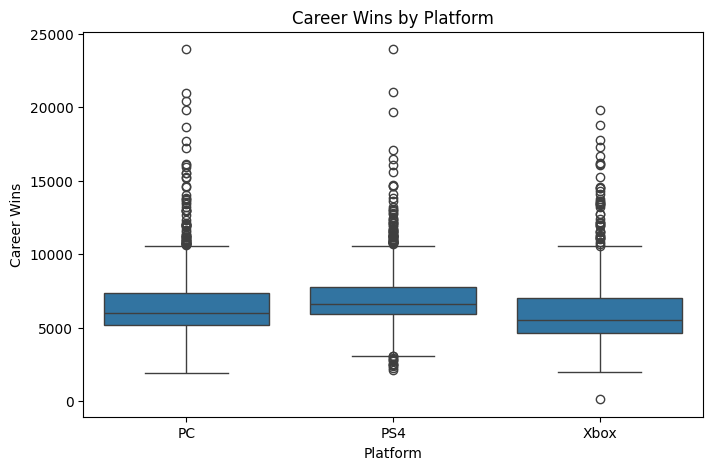

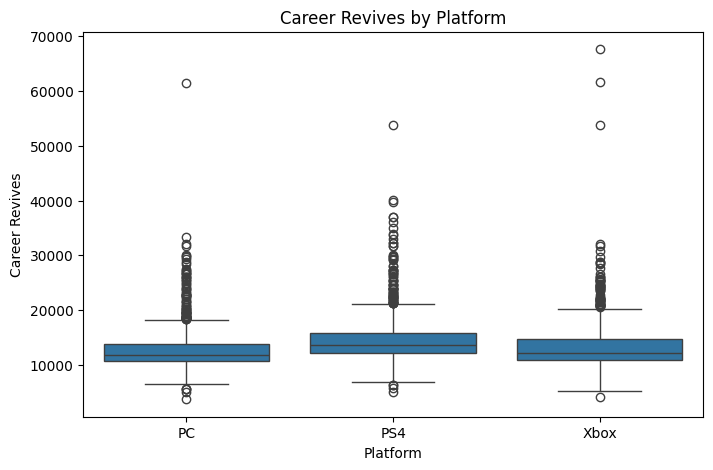

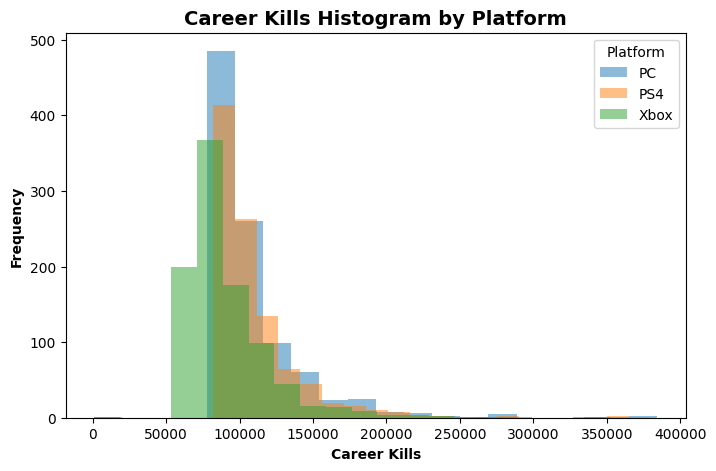

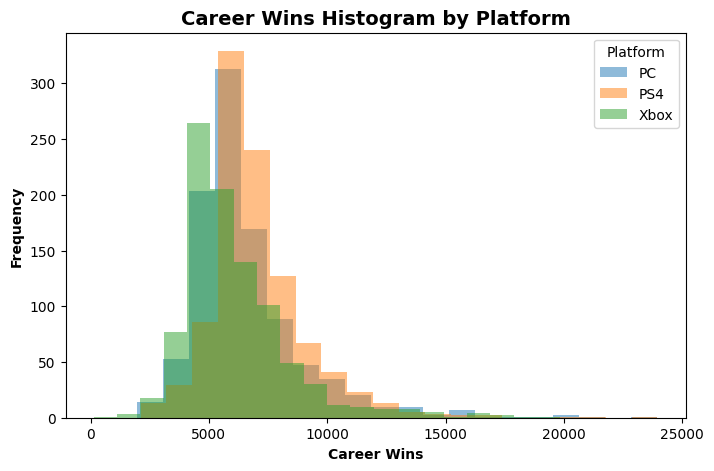

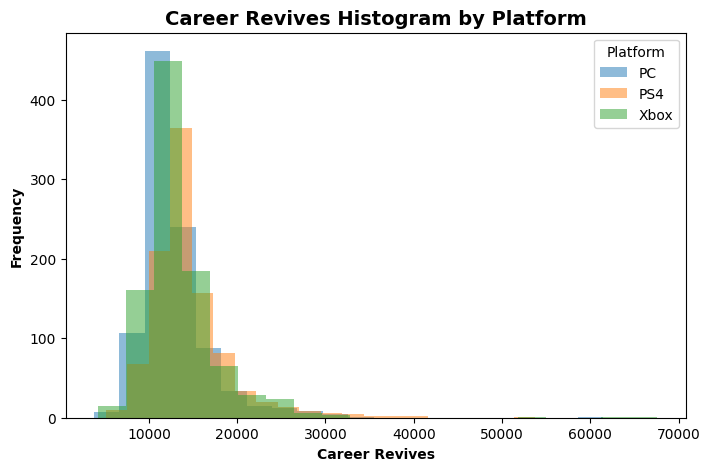

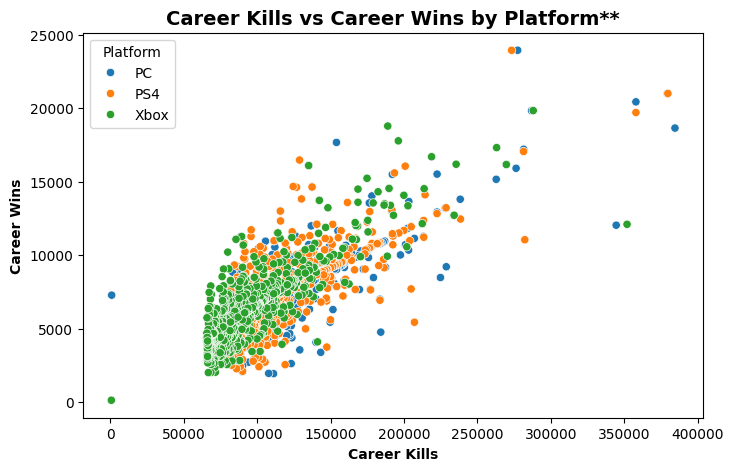

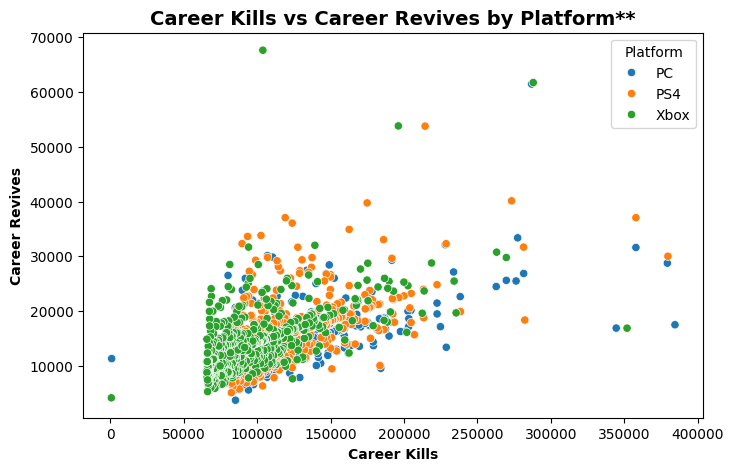

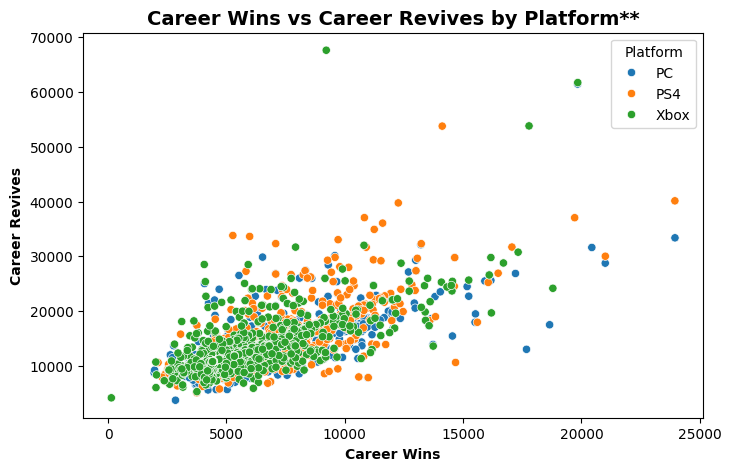

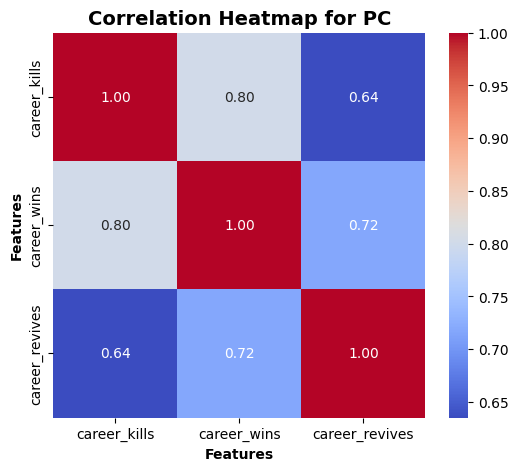

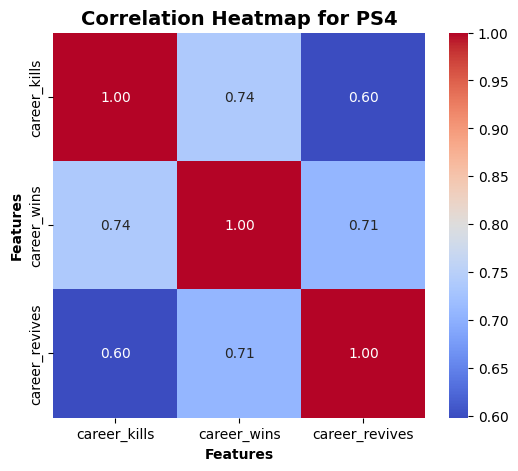

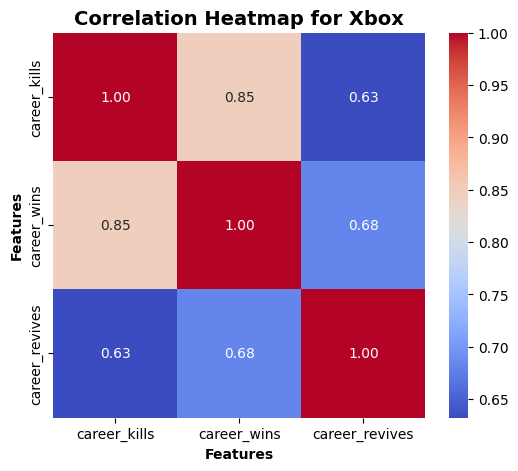

In [18]:
# Combine the data for plotting
pc_df['platform'] = 'PC'
ps4_df['platform'] = 'PS4'
xbox_df['platform'] = 'Xbox'
combined_df = pd.concat([pc_df, ps4_df, xbox_df], ignore_index=True)

# Boxplots for each feature by platform
features = ['career_kills', 'career_wins', 'career_revives']

for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='platform', y=feature, data=combined_df)
    plt.title(f'{feature.replace("_", " ").title()} by Platform')
    plt.ylabel(feature.replace("_", " ").title())
    plt.xlabel('Platform')
    plt.show()

# Histograms for each feature by platform
for feature in features:
    plt.figure(figsize=(8, 5))
    for platform in combined_df['platform'].unique():
        subset = combined_df[combined_df['platform'] == platform]
        plt.hist(subset[feature], bins=20, alpha=0.5, label=platform)
    plt.title(f'{feature.replace("_", " ").title()} Histogram by Platform', fontsize=14, fontweight='bold')
    plt.xlabel(f'{feature.replace("_", " ").title()}', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.legend(title='Platform')
    plt.show()

# Scatter plots between features, colored by platform
from itertools import combinations
for x_feature, y_feature in combinations(features, 2):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=combined_df, x=x_feature, y=y_feature, hue='platform')
    plt.title(f'{x_feature.replace("_", " ").title()} vs {y_feature.replace("_", " ").title()} by Platform**', fontsize=14, fontweight='bold')
    plt.xlabel(f'{x_feature.replace("_", " ").title()}', fontweight='bold')
    plt.ylabel(f'{y_feature.replace("_", " ").title()}', fontweight='bold')
    plt.legend(title='Platform')
    plt.show()

# Heatmaps of correlation matrices for each platform
for platform, df in zip(['PC', 'PS4', 'Xbox'], [pc_df, ps4_df, xbox_df]):
    plt.figure(figsize=(6, 5))
    corr = df.drop(columns=['player_name', 'platform'], errors='ignore').corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Heatmap for {platform}', fontsize=14, fontweight='bold')
    plt.xlabel('Features', fontweight='bold')
    plt.ylabel('Features', fontweight='bold')
    plt.show()

## Training a linear regression, MPL and XGBoost model to predict career_kills using only career_wins as input for a combined dataset of all platforms and then comparing the results of each model to determine which one performs best.

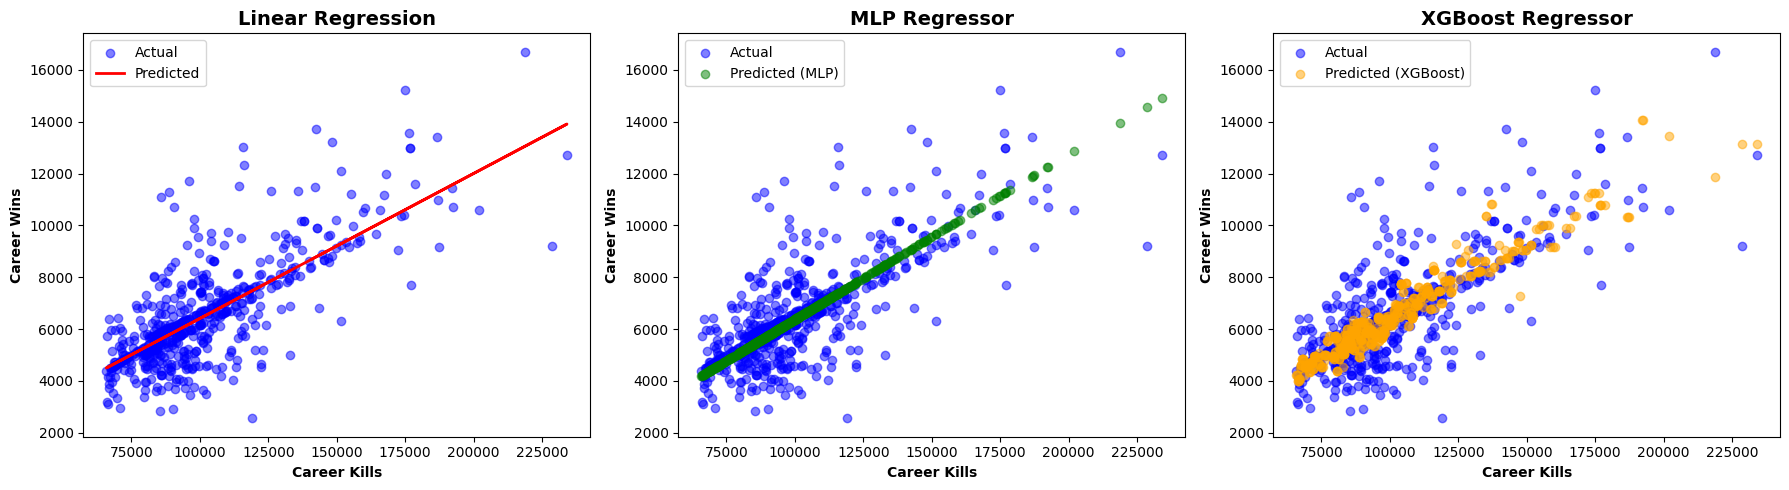

Linear Regression: Predicting Wins from Kills
MSE: 1778307.0729296166
R2: 0.5710671545709225

MLP Regressor: Predicting Wins from Kills
MSE: 1796796.7092685043
R2: 0.5666074004336786

XGBoost: Predicting Wins from Kills
MSE: 1911348.169388684
R2: 0.5389772546138915


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Combine all datasets into one DataFrame
combined_df = pd.concat([pc_df, ps4_df, xbox_df], ignore_index=True)
combined_df['platform'] = combined_df['platform'].astype('category').cat.codes  # Encode platform as numeric

# Predict career_wins using only career_kills as input
X_kills = combined_df[['career_kills']]
y_wins = combined_df['career_wins']

# Split into train and test sets
X_train_kills, X_test_kills, y_train_wins, y_test_wins = train_test_split(X_kills, y_wins, test_size=0.2, random_state=42)

# Train linear regression model
lr_kills = LinearRegression()
lr_kills.fit(X_train_kills, y_train_wins)
y_pred_wins_lr = lr_kills.predict(X_test_kills)

# MLP: Predict career_wins using only career_kills as input
mlp_kills = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp_kills.fit(X_train_kills, y_train_wins)
y_pred_wins_mlp = mlp_kills.predict(X_test_kills)

# XGBoost: Predict career_wins using only career_kills as input
xgb_kills = XGBRegressor(n_estimators=100, random_state=42)
xgb_kills.fit(X_train_kills, y_train_wins)
y_pred_wins_xgb = xgb_kills.predict(X_test_kills)

# Plot all results side by side
plt.figure(figsize=(18, 5))

# Linear Regression
plt.subplot(1, 3, 1)
plt.scatter(X_test_kills, y_test_wins, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test_kills, y_pred_wins_lr, color='red', linewidth=2, label='Predicted')
plt.title('Linear Regression', fontsize=14, fontweight='bold')
plt.xlabel('Career Kills', fontweight='bold')
plt.ylabel('Career Wins', fontweight='bold')
plt.legend()

# MLP
plt.subplot(1, 3, 2)
plt.scatter(X_test_kills, y_test_wins, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test_kills, y_pred_wins_mlp, color='green', alpha=0.5, label='Predicted (MLP)')
plt.title('MLP Regressor', fontsize=14, fontweight='bold')
plt.xlabel('Career Kills', fontweight='bold')
plt.ylabel('Career Wins', fontweight='bold')
plt.legend()

# XGBoost
plt.subplot(1, 3, 3)
plt.scatter(X_test_kills, y_test_wins, color='blue', alpha=0.5, label='Actual')
plt.scatter(X_test_kills, y_pred_wins_xgb, color='orange', alpha=0.5, label='Predicted (XGBoost)')
plt.title('XGBoost Regressor', fontsize=14, fontweight='bold')
plt.xlabel('Career Kills', fontweight='bold')
plt.ylabel('Career Wins', fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

# Print results at the end
print("Linear Regression: Predicting Wins from Kills")
print("MSE:", mean_squared_error(y_test_wins, y_pred_wins_lr))
print("R2:", r2_score(y_test_wins, y_pred_wins_lr))

print("\nMLP Regressor: Predicting Wins from Kills")
print("MSE:", mean_squared_error(y_test_wins, y_pred_wins_mlp))
print("R2:", r2_score(y_test_wins, y_pred_wins_mlp))

print("\nXGBoost: Predicting Wins from Kills")
print("MSE:", mean_squared_error(y_test_wins, y_pred_wins_xgb))
print("R2:", r2_score(y_test_wins, y_pred_wins_xgb))